In [2]:
import argparse
import torch
import tqdm
from src import utils as ut
from src.models.vaer import VAER
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [3]:
device = 'cpu'

comps_selection_metrics_dim=166
regression_metrics_dim=19
gen_weight=1
regressor_weight=100
nn='enc_dec_reg_v2'

train_set_df, val_set_df, test_set_df = ut.get_train_val_test_datasets()


In [6]:
def get_z(epoch, data_set_df):
    val_no_title_df = data_set_df.drop(['title_lower'], axis=1)
    X = val_no_title_df.iloc[:, :-1]
    y = val_no_title_df.iloc[:, -1:]
    vaer = VAER(comps_selection_metrics_dim=comps_selection_metrics_dim, regression_metrics_dim=regression_metrics_dim, nn=nn, gen_weight=gen_weight, regressor_weight=regressor_weight).to(device)
    vaer.eval()
    y_logits, reg_mse, z_m, z_v = vaer.validate_reg_output(torch.tensor(X.values).float().to(device), torch.tensor(y.values).float().to(device))
    z = pd.DataFrame(z_m.cpu().detach().numpy())
    return z

def validate_mse(data_set_df, from_epoch, to_epoch, step_epoch):
    val_no_title_df = data_set_df.drop(['title_lower'], axis=1)
    X = val_no_title_df.iloc[:, :-1]
    y = val_no_title_df.iloc[:, -1:]
    vaer = VAER(comps_selection_metrics_dim=comps_selection_metrics_dim, regression_metrics_dim=regression_metrics_dim, nn=nn, gen_weight=gen_weight, regressor_weight=regressor_weight).to(device)
    vaer.eval()
    for i in range(from_epoch, to_epoch, step_epoch):
        file_path = os.path.join('checkpoints',
                                 '{}'.format(vaer.nn),
                                 'model-{:05d}.pt'.format(i))
        state = torch.load(file_path, map_location=device)
        vaer.load_state_dict(state)
        y_hat, reg_mse, z_m, z_v = vaer.validate_reg_output(torch.tensor(X.values).float().to(device), torch.tensor(y.values).float().to(device))
        print(i, reg_mse.mean())
        
def prepare_plot(epoch, title):
    vaer = VAER(comps_selection_metrics_dim=comps_selection_metrics_dim, regression_metrics_dim=regression_metrics_dim, nn=nn, gen_weight=gen_weight, regressor_weight=regressor_weight).to(device)
    vaer.eval()
    file_path = os.path.join('checkpoints',
                             '{}'.format(vaer.nn),
                             'model-{:05d}.pt'.format(epoch))
    state = torch.load(file_path, map_location=device)
    vaer.load_state_dict(state)
    title_df = test_set_df[test_set_df['title_lower'] == title]
    title_df = title_df.drop(['title_lower'], axis=1)
    X = title_df.iloc[:, :-1]
    y = title_df.iloc[:, -1:]
    y_logits, reg_mse, z_m, z_v  = vaer.validate_reg_output(torch.tensor(X.values).float().to(device), torch.tensor(y.values).float().to(device))
    print('mse: ', reg_mse.mean())
    y_hat = pd.DataFrame(y_logits.cpu().detach().numpy())
    weeknum = X[['1/weeknum']]
    y_hat.reset_index(drop=True, inplace=True)
    weeknum.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    # Place the DataFrames side by side
    df = pd.concat([weeknum, y, y_hat], ignore_index=True, axis=1)
    df = df.rename(columns = {0: "1/weeknum", 1:"units_actual", 2: "units_predicted"}) 
    df['weeknum'] = df.apply (lambda row: 1.0/row['1/weeknum'], axis=1)
    
    return df

def plot(df, title):
    # gca stands for 'get current axis'
    ax = plt.gca()

    df.plot(kind='line',x='weeknum',y='units_actual', color='blue', ax=ax)
    df.plot(kind='line',x='weeknum',y='units_predicted', color='orange', ax=ax)
    plt.title(title)
    plt.show()
        

In [ ]:
validate_mse(val_set_df, 50,1001,50)

In [10]:
validate_mse(test_set_df, 200,201,10)

200 tensor(0.6864, grad_fn=<MeanBackward0>)


mse:  tensor(0.0859, grad_fn=<MeanBackward0>)


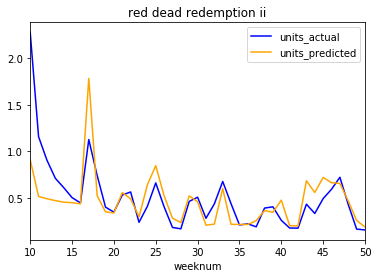

In [22]:
plot(prepare_plot(200, 'red dead redemption ii'), 'red dead redemption ii')


mse:  tensor(0.5955, grad_fn=<MeanBackward0>)


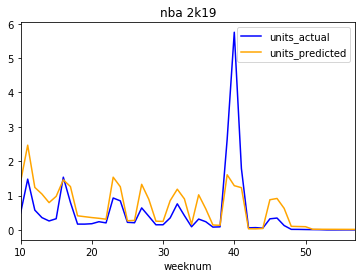

In [23]:
plot(prepare_plot(200, 'nba 2k19'), 'nba 2k19')


mse:  tensor(0.0821, grad_fn=<MeanBackward0>)


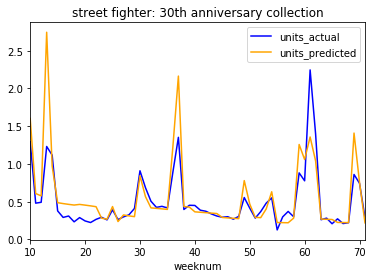

In [24]:
plot(prepare_plot(200, 'street fighter: 30th anniversary collection'), 'street fighter: 30th anniversary collection')

mse:  tensor(0.3820, grad_fn=<MeanBackward0>)


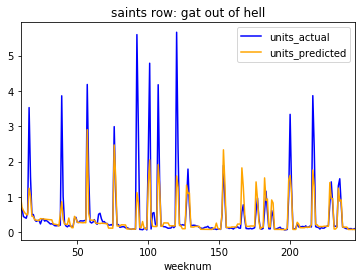

In [7]:
plot(prepare_plot(200, 'saints row: gat out of hell'), 'saints row: gat out of hell')

mse:  tensor(0.6375, grad_fn=<MeanBackward0>)


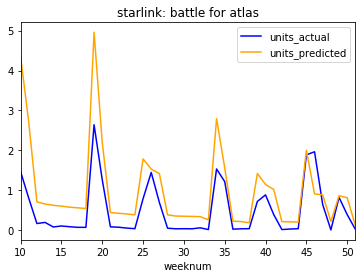

In [8]:
plot(prepare_plot(200, 'starlink: battle for atlas'), 'starlink: battle for atlas')

mse:  tensor(0.2295, grad_fn=<MeanBackward0>)


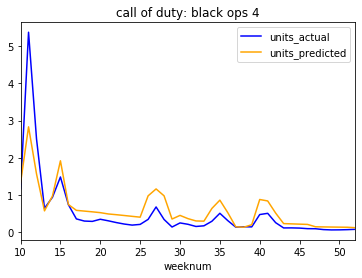

In [9]:
plot(prepare_plot(200, 'call of duty: black ops 4'), 'call of duty: black ops 4')

In [ ]:
z = get_z(200, pd.concat([train_set_df,val_set_df], ignore_index=True))
tsne = MDS(n_components=2, random_state=0)
X_2d = tsne.fit_transform(z.values)

#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_2d[:, 0], X_2d[:, 1])
plt.title('TSNE visualization of latent space')
ax.axis('equal')